# Notebook for Metallurgy project
## Transcription 

Test and evaluate different pitch summary methods: 
1. Value at onset -> Use result_array (numpy 2d array) to use frequency, onset and loudness information!
2. Average from one onset to next onset -> Use result_array_average_onset
3. Median from one onset to next onset -> result_array_median_onset
4. Average for 5ms from onset 
5. Median for 5ms from onset 

### 1. Value at onset

In [1]:
# imports library for transcription
%matplotlib inline
import numpy as np
import librosa
import librosa.display
import essentia
from essentia.standard import *
import essentia.streaming as ess
import matplotlib.pyplot as plt
from pylab import plot, show, figure, imshow
plt.rcParams['figure.figsize'] = (15, 6) # Set plot sizes
import IPython
#import mido
from mir_eval.sonify import pitch_contour

In [2]:
# Loudness is optional on August 2020 but will be used for the future version
loader = EqloudLoader(filename='../Audio/test/test_twinkle.wav', sampleRate=44100)
audio = loader()
print("Duration of the audio sample [sec]:")
print(len(audio)/44100.0)
level_extractor = LevelExtractor(frameSize=1024, hopSize=128)(audio)
print(level_extractor)

Duration of the audio sample [sec]:
10.402539682539683
[9.0294914e+00 9.6462336e+00 1.0096562e+01 ... 2.0300606e-12 1.9762371e-12
 1.9603720e-12]


In [3]:
# Load audio files
audio1 = MonoLoader(filename='../Audio/test/LeadSamples-C4_Clean-18.4.wav')()
audio2 = MonoLoader(filename='../Audio/test/LeadSamples-D4_Clean-17.1.wav')()
audio3 = MonoLoader(filename='../Audio/test/LeadSamples-Eb4_Clean-19.8.wav')()
audio_test = MonoLoader(filename='../Audio/test/test_twinkle.wav')()
# Phase 1: compute the onset detection function
# The OnsetDetection algorithm provides various onset detection functions. Let's use two of them.

od1 = OnsetDetection(method='hfc')
od2 = OnsetDetection(method='complex')

# Let's also get the other algorithms we will need, and a pool to store the results
w = Windowing(type = 'hann')
fft = FFT() # this gives us a complex FFT
c2p = CartesianToPolar() # and this turns it into a pair (magnitude, phase)
pool = essentia.Pool()

# Computing onset detection functions.
for frame in FrameGenerator(audio_test, frameSize = 1024, hopSize = 512):
    mag, phase, = c2p(fft(w(frame)))
    pool.add('features.hfc', od1(mag, phase))
    pool.add('features.complex', od2(mag, phase))

# Phase 2: compute the actual onsets locations
onsets = Onsets()

onsets_hfc = onsets(# this algo expects a matrix, not a vector
                    essentia.array([ pool['features.hfc'] ]),

                    # you need to specify weights, but as there is only a single
                    # function, it doesn't actually matter which weight you give it
                    [ 1 ])

onsets_complex = onsets(essentia.array([ pool['features.complex'] ]), [ 1 ])


# Mark onsets on the audio, which we'll write back to disk
# We use beeps instead of white noise and stereo signal as it's more distinctive

silence = [0.] * len(audio_test)

beeps_hfc = AudioOnsetsMarker(onsets=onsets_hfc, type='beep')(silence)
AudioWriter(filename='../Audio/test/twinkle_onsets_hfc_stereo.wav', format='wav')(StereoMuxer()(audio_test, beeps_hfc))

beeps_complex = AudioOnsetsMarker(onsets=onsets_complex, type='beep')(silence)
AudioWriter(filename='../Audio/test/twinkle_onsets_complex_stereo.wav', format='wav')(StereoMuxer()(audio_test, beeps_complex))



onset(sec)
Time [0.01160998 0.55727893 1.11455786 1.67183673 2.22911572 2.77478456
 3.33206344 4.44662142 5.00390005 5.54956913 6.10684824 6.66412687
 7.22140598 7.77868462]
Frame Time [   511.9999906   24576.00086331  49152.00172663  73727.99996138
  98304.00345325 122367.99931526 146943.99755001 196096.00453377
 220671.99225426 244735.99863052 269312.00737953 293887.99510002
 318464.00384903 343039.99156952]


Text(0.5, 1.0, 'Audio waveform and the estimated onset positions (complex onset detection function)')

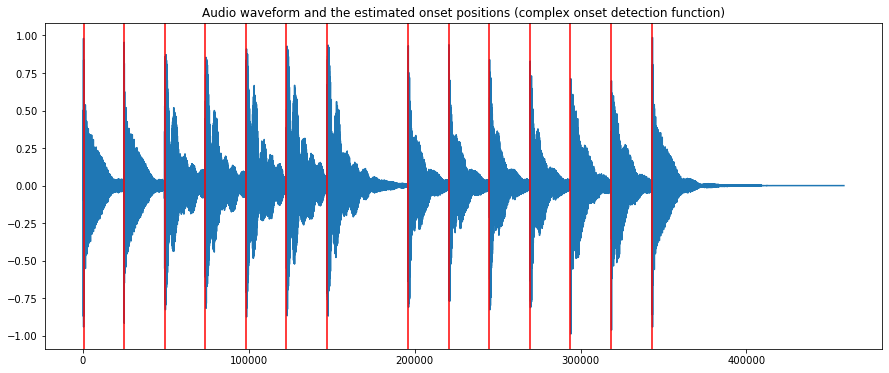

In [4]:
plot(audio_test)
print('onset(sec)')
# For loop: making 2d numpy arrays for processing frequency, tiem and level
time = []
frame_time = []
for onset in onsets_complex:
    plt.axvline(x=onset*44100, color='red')
    frame_time = np.append(frame_time,onset*44100)
    time = np.append(time, onset)
time = np.array(time)
print("Time",time)
print("Frame Time",frame_time)
plt.title("Audio waveform and the estimated onset positions (complex onset detection function)")

Duration of the audio sample [sec]:
10.402539682539683


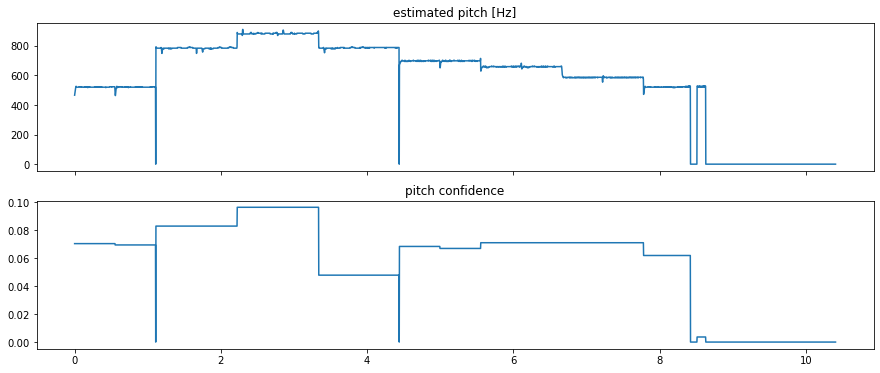

In [30]:
# Load audio file; it is recommended to apply equal-loudness filter for PredominantPitchMelodia
loader = EqloudLoader(filename='../Audio/test/test_twinkle.wav', sampleRate=44100)
audio = loader()
print("Duration of the audio sample [sec]:")
print(len(audio)/44100.0)

# Extract the pitch curve
# PitchMelodia takes the entire audio signal as input (no frame-wise processing is required)

#TEST
pitch_extractor = PitchMelodia(frameSize=1024, hopSize=128)
pitch_values, pitch_confidence = pitch_extractor(audio)

# Pitch is estimated on frames. Compute frame time positions
pitch_times = np.linspace(0.0,len(audio)/44100.0,len(pitch_values) )

# Plot the estimated pitch contour and confidence over time
f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(pitch_times, pitch_values)
axarr[0].set_title('estimated pitch [Hz]')
axarr[1].plot(pitch_times, pitch_confidence)
axarr[1].set_title('pitch confidence')
plt.show()

In [31]:
loader = EqloudLoader(filename='../Audio/test/test_twinkle.wav', sampleRate=44100)
audio = loader()
print("Duration of the audio sample [sec]:")
print(len(audio)/44100.0)
level_extractor = LevelExtractor(frameSize=1024, hopSize=128)(audio)
print(level_extractor)

Duration of the audio sample [sec]:
10.402539682539683
[9.0294914e+00 9.6462336e+00 1.0096562e+01 ... 1.9284524e-12 1.9688157e-12
 1.9404279e-12]


In [32]:
# round decimals
time = np.around(time,decimals=5)
pitch_times = np.around(pitch_times,decimals=5)
level_extractor = np.around(level_extractor,decimals=5)
pitch=[]
level=[]
print("Onset[sec]:",time)
for i in range(0,len(time)):
    where_pitch=np.where(pitch_times==time[i])
    where_pitch_int=int(where_pitch[0])
    pitch=np.append(pitch,pitch_values[where_pitch_int])
    level=np.append(level,level_extractor[where_pitch_int])

print("Frequency[Hz]:",pitch)
print("Level[Hz]:",level)

Onset[sec]: [0.01161 0.55728 1.11456 1.67184 2.22912 2.77478 3.33206 4.44662 5.0039
 5.54957 6.10685 6.66413 7.22141 7.77868]
Frequency[Hz]: [508.36184692 463.48468018 788.54492188 774.99810791 880.01446533
 869.90655518 900.5838623  678.58282471 682.51385498 714.79296875
 682.51385498 625.86761475 573.92285156 471.58633423]
Level[Hz]: [ 7.72759008  9.0831604  11.34836006 10.97758961 11.72159004  9.43760014
  9.83481979 10.28044987  9.67354012  8.40764999  8.76084042  6.97849989
  7.20269012  9.20660019]


In [33]:
# Convert lists into array
pitch=np.array(pitch)
time=np.array(time)
level = np.array(level)
params=np.array([])
# For loop for making 1d numpy array
for k in range(0,len(time),1):
    temp = [pitch[k], time[k], level[k]]
    temp=np.array(temp)
    params=np.append(params, temp)
result_array = np.zeros((len(time),3))
k=0
# For loop for making 2d numpy array
for i in range(len(time)):
    for j in range(3):
        result_array[i][j]= params[k]
        k=k+1
print("[ [frequency, time, level], [frequency, time, level], [frequency, time, level] ... ] ")
print(result_array)
print(result_array.shape)

[ [frequency, time, level], [frequency, time, level], [frequency, time, level] ... ] 
[[5.08361847e+02 1.16100000e-02 7.72759008e+00]
 [4.63484680e+02 5.57280000e-01 9.08316040e+00]
 [7.88544922e+02 1.11456000e+00 1.13483601e+01]
 [7.74998108e+02 1.67184000e+00 1.09775896e+01]
 [8.80014465e+02 2.22912000e+00 1.17215900e+01]
 [8.69906555e+02 2.77478000e+00 9.43760014e+00]
 [9.00583862e+02 3.33206000e+00 9.83481979e+00]
 [6.78582825e+02 4.44662000e+00 1.02804499e+01]
 [6.82513855e+02 5.00390000e+00 9.67354012e+00]
 [7.14792969e+02 5.54957000e+00 8.40764999e+00]
 [6.82513855e+02 6.10685000e+00 8.76084042e+00]
 [6.25867615e+02 6.66413000e+00 6.97849989e+00]
 [5.73922852e+02 7.22141000e+00 7.20269012e+00]
 [4.71586334e+02 7.77868000e+00 9.20660019e+00]]
(14, 3)


### 2. Average from one onset to next onset

In [35]:
# round decimals
time = np.around(time,decimals=5)
pitch_times = np.around(pitch_times,decimals=5)
level_extractor = np.around(level_extractor,decimals=5)
pitch=[]
level=[]
print("Onset[sec]:",time)
for i in range(0,len(time)):
    if i >=0 and i<= (len(time)-2):
        where_pitch_1=np.where(pitch_times==time[i])
        where_pitch_2=np.where(pitch_times==time[i+1])
        where_pitch_int1=int(where_pitch_1[0])
        where_pitch_int2=int(where_pitch_2[0])
        pitch_values_average = np.array(pitch_values[where_pitch_int1:where_pitch_int2])
        pitch_values_average = pitch_values_average[(pitch_values_average > 0)]
        average_pitch = np.mean(pitch_values_average)
        pitch=np.append(pitch,average_pitch)
        level=np.append(level,level_extractor[where_pitch_int1])
    else:
        where_pitch_1=np.where(pitch_times==time[i])
        where_pitch_int1=int(where_pitch_1[0])
        pitch_values_average = np.array(pitch_values[where_pitch_int1:])
        pitch_values_average = pitch_values_average[(pitch_values_average > 0)]
        average_pitch = np.mean(pitch_values_average)
        pitch=np.append(pitch,average_pitch)
        level=np.append(level,level_extractor[where_pitch_int1]) 
    
        

print("Frequency[Hz]:",pitch)
print("Level[Hz]:",level)


Onset[sec]: [0.01161 0.55728 1.11456 1.67184 2.22912 2.77478 3.33206 4.44662 5.0039
 5.54957 6.10685 6.66413 7.22141 7.77868]
Frequency[Hz]: [520.86834717 521.80426025 783.88427734 785.16644287 882.75939941
 883.02130127 786.16760254 697.00195312 697.80718994 658.53808594
 658.48181152 586.20861816 586.12469482 521.49938965]
Level[Hz]: [ 7.72759008  9.0831604  11.34836006 10.97758961 11.72159004  9.43760014
  9.83481979 10.28044987  9.67354012  8.40764999  8.76084042  6.97849989
  7.20269012  9.20660019]


In [40]:
# Convert lists into array
pitch=np.array(pitch)
time=np.array(time)
level = np.array(level)
params=np.array([])
# For loop for making 1d numpy array
for k in range(0,len(time),1):
    temp = [pitch[k], time[k], level[k]]
    temp=np.array(temp)
    params=np.append(params, temp)
result_array_mean_onset = np.zeros((len(time),3))
k=0
# For loop for making 2d numpy array
for i in range(len(time)):
    for j in range(3):
        result_array_mean_onset[i][j]= params[k]
        k=k+1
print("[ [frequency, time, level], [frequency, time, level], [frequency, time, level] ... ] ")
print(result_array_mean_onset)
print(result_array_mean_onset.shape)

[ [frequency, time, level], [frequency, time, level], [frequency, time, level] ... ] 
[[5.20244324e+02 1.16100000e-02 7.72759008e+00]
 [5.20244324e+02 5.57280000e-01 9.08316040e+00]
 [7.84003174e+02 1.11456000e+00 1.13483601e+01]
 [7.84003174e+02 1.67184000e+00 1.09775896e+01]
 [8.80014465e+02 2.22912000e+00 1.17215900e+01]
 [8.85112305e+02 2.77478000e+00 9.43760014e+00]
 [7.88544922e+02 3.33206000e+00 9.83481979e+00]
 [6.98466919e+02 4.44662000e+00 1.02804499e+01]
 [6.98466919e+02 5.00390000e+00 9.67354012e+00]
 [6.59264771e+02 5.54957000e+00 8.40764999e+00]
 [6.59264771e+02 6.10685000e+00 8.76084042e+00]
 [5.87337769e+02 6.66413000e+00 6.97849989e+00]
 [5.87337769e+02 7.22141000e+00 7.20269012e+00]
 [5.20244324e+02 7.77868000e+00 9.20660019e+00]]
(14, 3)


### 3. Median from one onset to next onset

In [37]:
# round decimals
time = np.around(time,decimals=5)
pitch_times = np.around(pitch_times,decimals=5)
level_extractor = np.around(level_extractor,decimals=5)
pitch=[]
level=[]
print("Onset[sec]:",time)
for i in range(0,len(time)):
    if i >=0 and i<= (len(time)-2):
        print(i)
        where_pitch_1=np.where(pitch_times==time[i])
        where_pitch_2=np.where(pitch_times==time[i+1])
        where_pitch_int1=int(where_pitch_1[0])
        where_pitch_int2=int(where_pitch_2[0])
        pitch_values_average = np.array(pitch_values[where_pitch_int1:where_pitch_int2])
        pitch_values_average = pitch_values_average[(pitch_values_average > 0)]
        average_pitch = np.median(pitch_values_average)
        pitch=np.append(pitch,average_pitch)
        level=np.append(level,level_extractor[where_pitch_int1])
        print("Frequency[Hz]:",pitch)
    else:
        print("except",i)
        where_pitch_1=np.where(pitch_times==time[i])
        where_pitch_int1=int(where_pitch_1[0])
        pitch_values_average = np.array(pitch_values[where_pitch_int1:])
        pitch_values_average = pitch_values_average[(pitch_values_average > 0)]
        average_pitch = np.median(pitch_values_average)
        pitch=np.append(pitch,average_pitch)
        level=np.append(level,level_extractor[where_pitch_int1]) 
    
        

print("Frequency[Hz]:",pitch)
print("Level[Hz]:",level)


Onset[sec]: [0.01161 0.55728 1.11456 1.67184 2.22912 2.77478 3.33206 4.44662 5.0039
 5.54957 6.10685 6.66413 7.22141 7.77868]
0
Frequency[Hz]: [520.24432373]
1
Frequency[Hz]: [520.24432373 520.24432373]
2
Frequency[Hz]: [520.24432373 520.24432373 784.00317383]
3
Frequency[Hz]: [520.24432373 520.24432373 784.00317383 784.00317383]
4
Frequency[Hz]: [520.24432373 520.24432373 784.00317383 784.00317383 880.01446533]
5
Frequency[Hz]: [520.24432373 520.24432373 784.00317383 784.00317383 880.01446533
 885.11230469]
6
Frequency[Hz]: [520.24432373 520.24432373 784.00317383 784.00317383 880.01446533
 885.11230469 788.54492188]
7
Frequency[Hz]: [520.24432373 520.24432373 784.00317383 784.00317383 880.01446533
 885.11230469 788.54492188 698.46691895]
8
Frequency[Hz]: [520.24432373 520.24432373 784.00317383 784.00317383 880.01446533
 885.11230469 788.54492188 698.46691895 698.46691895]
9
Frequency[Hz]: [520.24432373 520.24432373 784.00317383 784.00317383 880.01446533
 885.11230469 788.54492188 698.

In [42]:
# Convert lists into array
pitch=np.array(pitch)
time=np.array(time)
level = np.array(level)
params=np.array([])
# For loop for making 1d numpy array
for k in range(0,len(time),1):
    temp = [pitch[k], time[k], level[k]]
    temp=np.array(temp)
    params=np.append(params, temp)
result_array_median_onset = np.zeros((len(time),3))
k=0
# For loop for making 2d numpy array
for i in range(len(time)):
    for j in range(3):
        result_array_median_onset[i][j]= params[k]
        k=k+1
print("[ [frequency, time, level], [frequency, time, level], [frequency, time, level] ... ] ")
print(result_array_median_onset)
print(result_array_median_onset.shape)

[ [frequency, time, level], [frequency, time, level], [frequency, time, level] ... ] 
[[5.20244324e+02 1.16100000e-02 7.72759008e+00]
 [5.20244324e+02 5.57280000e-01 9.08316040e+00]
 [7.84003174e+02 1.11456000e+00 1.13483601e+01]
 [7.84003174e+02 1.67184000e+00 1.09775896e+01]
 [8.80014465e+02 2.22912000e+00 1.17215900e+01]
 [8.85112305e+02 2.77478000e+00 9.43760014e+00]
 [7.88544922e+02 3.33206000e+00 9.83481979e+00]
 [6.98466919e+02 4.44662000e+00 1.02804499e+01]
 [6.98466919e+02 5.00390000e+00 9.67354012e+00]
 [6.59264771e+02 5.54957000e+00 8.40764999e+00]
 [6.59264771e+02 6.10685000e+00 8.76084042e+00]
 [5.87337769e+02 6.66413000e+00 6.97849989e+00]
 [5.87337769e+02 7.22141000e+00 7.20269012e+00]
 [5.20244324e+02 7.77868000e+00 9.20660019e+00]]
(14, 3)


### 4. Average for 5ms from onset

## Sampler 
### Notes, thoughts, and ideas
Collected here are some notes to remember, thoughts on the code, and ideas for future implementation.

### Features to implement
- Create midi file
    - This can be an additional output option for automatic transcription
    - Use mido library
    - Translate note information to MIDI
        - For each note data provided by the analysis, create an associated MIDI note
- ADSR for the samples
    - Initially implement attack and release
    - Attack: Time in ms that the sample ramps in from 0 to 1.
        - Min = 1 ms? This would be 44 samples at 44.1k. 0.5 ms would be 22 samples. That's a plenty short period of time.
        - Max = 1 sec?
    - Release: Time in ms the sample ramps out from 1 to 0.
    - Should the scaling be linear? Exponential?
- Move the `add_sample()` function to the functions cell for general use.
- The `add_sample()` function may need adjustment when Keon let's me know what the formatting will be for data array.

In [43]:
# imports library for the sampler
import os
import IPython
import numpy as np
from scipy.io import wavfile
import wavio
import librosa

In [44]:
# functions

def load_wav(file):
    '''
    Import 24-bit wav files and convert to 32-bit float
    
    Parameters
    ----------
    file       : wav file
        Wav file to be loaded.
    
    Returns
    -------
    data          : np.array [shape=(?), dtype=np.float32]
        Wav sample data
    rate          : int
        Samplerate associated with the wav file loaded
    
    Notes
    -----
    Conversion    : May need to add conversion cases for 16-bit audio. 32-bit
                    wav files are uncommon so probably not necessary for this
                    project.
    '''
    wav = wavio.read(file)
    # convert from 24-bit in to 32-bit float
    data = np.zeros(len(wav.data), dtype=np.float32)
    if wav.data.dtype==np.int32 and wav.sampwidth==3:
        for smp in range(len(wav.data)):
            data[smp] = wav.data[smp] / 8388608.0
    return data, wav.rate



def convert_samplerate(data, original_sr, target_sr=44100):
    '''
    Convert audio of an aribtrary samplerate to 44.1 kHz
    Input:      wav data, wave data samplerate
    Output:     resampled wav data
    '''
    if original_sr != target_sr:
        resampled_data = librosa.resample(data, original_sr, target_sr)
        return resampled_data
    else:
        return data
    

    
def hz_to_midi(frequency):
    '''
    Convert a frequency to its corresponding midi value.
    
    Parameters
    ----------
    frequency       : float
        frequency to convert
    
    Returns
    -------
    midi_note_num   : float
        MIDI note number (fractional) that corresponds to the input frequency
    '''
    return 12 * (np.log2(frequency) - np.log2(440.0)) + 69



def add_sample(input_array, output_audio):
    '''
    Add an audio sample to the audio output.
    
    Parameters
    ----------
    input_array     : np.ndarray [shape=(2,), dtype=float]
        Input array to be processed
        Element 0   : Note frequency in hz
        Element 1   : Time placement in output file in sec
        
    output_audio    : np.ndarray [shape=(n,), dtype=np.float32]
        Array containing audio data for final output
        
    Returns
    -------
    output_audio is returned after adding the audio sample
    '''
    # Calculate midi note of input frequency (currently as an int)
    midi_note_num = np.rint(hz_to_midi(input_array[0])).astype(int)
    
    # Determine the file name of the sample to use
    # TODO: convert this to own function?
    sample_file_name = str(midi_note_num) + "/Lead-" + str(midi_note_num) + "-6.wav"
    
    # Determine the location of the sample to use
    sample_path = os.path.join("../Audio/MetallurgySamples/", sample_file_name)
    
    # Convert time in sec to sample position
    start_pos = int(_samplerate * input_array[1])
    
    # Load sample data
    sample, sr = load_wav(sample_path)
    
    # Check sample samplerate
    if sr != 44100:
        sample = convert_samplerate(sample, sr)
    
    # Check output_audio array length to make sure sample being added doesn't overrun it
    sample_length = len(sample)
    space_left = len(output_audio) - start_pos
    if sample_length >= space_left:
        padding = np.zeros(sample_length - space_left + 1, dtype=np.float32)
        output_audio = np.concatenate([output_audio, padding])
    
    # Ramp in
    sample = add_attack(sample)
        
    # Ramp out
    sample = add_release(sample)
    
    # Add sample data to output_audio array
    for smp in range(len(sample)):
        output_audio[start_pos + smp] += sample[smp]
    
    return output_audio



def add_attack(sample, attack_time=1, samplerate=44100):
    '''
    Add an attack ramp to a sample.
    
    Parameters
    ----------
    sample : np.ndarry [ shape = (n,), dtype=np.float32 ]
        Sample to add attack ramp to
        
    attack_time : float
        Ramp length in milliseconds. Must be >= 0 and less than the
        length of the input sample.
        
    samplerate : int > 0
        The samplerate for the sample.
        
    Returns
    -------
    processed_sample : np.ndarray [ shape = (n,), dtype=np.float32 ]
        Returns the processed sample array.
    '''
    
    assert attack_time >= 0, "Attack time is negative."
    assert attack_time < len(sample), "Attack time is longer than sample."
    assert samplerate > 0, "Samplerate is not a positive integer."
    
    ramp_time = int(np.floor(attack_time * samplerate / 1000))
    for smp in range(ramp_time):
        sample[smp] *= smp / ramp_time
    return sample



def add_release(sample, release_time=1, samplerate=44100):
    '''
    Add a release ramp to a sample.
    
    Parameters
    ----------
    sample : np.ndarray [ shape = (n,), dtype=np.float32 ]
        Sample to add release ramp to
        
    release_time : float
        Rampl length in milliseconds. Must be >= 0 and less than the
        length of the input sample.
        
    samplerate : int > 0
        The samplerate for the sample.
        
    Returns
    -------
    processed_sample : np.ndarray [ shape = (n,), dtype=np.float32 ]
        Returns the processed sample array.
    
    '''
    
    assert release_time >= 0, "Release time is negative."
    assert release_time < len(sample), "Release time is longer than the sample."
    assert samplerate > 0, "Samplerate is not a positive integer."
    
    ramp_time = int(np.floor(release_time * samplerate / 1000))
    for smp in range(ramp_time):
        sample[-smp-1] *= smp/ramp_time
    
    return sample

#TODO: Create combined AR (attack/release function) that calls add_attack, add_release, and checks 

## Setup

We'll process all audio as 32-bit floats in the range [-1.0,1.0] and convert to 24-bit int values at the end. 32-bit float allows audio from different source rates to interact naturally without the need for constant conversion. Just convert at the beginning and end.

We should use just one samplerate for everything. I prefer 48 kHz to 44.1 kHz, but 44.1 kHz seems to be the standard due to the influence of CD audio. We should create a function to the check the samplerate of audio as it is loaded and if it not 44.1, then convert it.

In [47]:
_samplerate = 44100

In [48]:
# Set up the output audio array
output = np.zeros(1, dtype = np.float32)

# Add the samples to the output array
for note in result_array_mean_onset:
    output = add_sample(note, output)

In [49]:
wavfile.write("../Audio/test/mean_output.wav", _samplerate, output)

In [50]:
IPython.display.Audio('../Audio/test/mean_output.wav')